# Análise de Eficiência de Fretes
Este projeto tem como objetivo analisar dados de distribuição de livros didáticos a partir do **Centro de Distribuição (CD)**, identificando **fretes ineficientes** e propondo **recomendações para otimizar**.

Iremos dividir este projeto em três partes:

- 1. Entendimento e Preparação dos Dados
- 2. Definição de Métricas e Análise Exploratória
- 3. Modelagem e Recomendações

 ## 1: Entendimento e Preparação dos Dados

Vamos inciar com a inspeção dos dados com objetivo de identificar os formatos, datas, valores nulos, duplicidades e outras inconsistências.

Temos duas bases de dados, são elas:

- `base_informações.csv` que contem as seguintes colunas:

    - **ID_Pedido:** Código único de identificação do pedido;
    - **Data:** Data do pedido;
    - **Modal:** Modal usado para o transporte;
    - **Cidade:** Cidade de destino da entrega;
    - **Valor_pedido:** Valor do pedido.

- `base_pedidos.csv` que contem as seguintes colunas:
    - **ID_Pedido:** Código único de identificação do pedido;
    - **Distância:** Distância entre o CD (Centro de Distribuição) e o cliente (Vamos assumir que a distância está em Km);
    - **Peso_Kg:** Peso em Kilograma do pedido;
    - **Preco_custo:** Preço de custo do pedido, no caso do material dos livros;
    - **Custo_Frete:** Custo do frete.

    Outras informações são: 

    - **Modal de Transporte Dedicado:** consiste na contratação de um veículo exclusivo pelo Centro
    de Distribuição (CD), diretamente com a transportadora, para o transporte de uma carga
    fechada. Esse modal possui uma capacidade máxima de 1.500 kg.
    - **Modal de Transporte Fracionado:** ocorre quando o Centro de Distribuição (CD) encaminha o
    pedido do cliente por meio de uma transportadora. A transportadora realiza a coleta da
    mercadoria e a entrega ao cliente utilizando sua logística já estruturada, consolidando a
    carga com os pedidos de outros clientes atendidos pela transportadora.
    - Por padrão, todos os pedidos têm origem com o modal de entrega Fracionado. 
    O representante comercial da Somos Educação pode realizar uma solicitação ao CD para
    transformar o modal em Dedicado.
    - Toda alteração de modal Fracionado para Dedicado deve ser aprovado pelo time competente no CD.

In [1]:
# Importando as bibliotecas
import pandas as pd
import numpy as np

# Visualização 
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML # type: ignore
import plotly.graph_objects as go # type: ignore

# Algumas configurações
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Configuração para o notebook e plotagem de imagens
%matplotlib inline
def jupyter_settings():
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display(HTML('<style>.container { width:100% !important; }</style>'))
    sns.set()

jupyter_settings()


### 1.1: Importando o conjunto de dados

In [2]:
# Importando as duas bases de dados
df_info = pd.read_csv('../data/base_informações.csv', sep=';')
df_pedidos = pd.read_csv('../data/base_pedidos.csv', sep=';')

In [3]:
# visualizando a primeira base
df_info.head()

,ID_Pedido,Distancia,Peso_Kg,Preco_custo,Custo_Frete
0,F1,812,881,22025,5000
1,F2,868,882,22050,5000
2,F3,864,938,23450,5000
3,F4,828,970,24250,5000
4,F5,797,853,21325,5000


In [4]:
df_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   ID_Pedido    1048575 non-null  object
 1   Distancia    1048575 non-null  int64 
 2   Peso_Kg      1048575 non-null  int64 
 3   Preco_custo  1048575 non-null  int64 
 4   Custo_Frete  1048575 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 40.0+ MB


Para a base de dados `df_info`temos ao todo 1048575 entradas e a princípio todas as colunas não possuem nenhuma entrada nula. Também temos o fato que a coluna `ID_Pedido` é do formato objeto. As demais colunas são do tipo inteiro, condizentes com suas tipologias.

In [5]:
# Visualizando a segunda base
df_pedidos.head()

,ID_Pedido,Data,Modal,Cidade,Valor_pedido
0,F1,19APR2020,Dedicado,Florianopolis,52860
1,F2,16AUG2024,Dedicado,Florianopolis,52920
2,F3,10/nov/24,Dedicado,Florianopolis,56280
3,F4,07AUG2022,Dedicado,Florianopolis,58200
4,F5,14SEP2020,Dedicado,Florianopolis,51180


In [6]:
df_pedidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   ID_Pedido     1048575 non-null  object
 1   Data          1048575 non-null  object
 2   Modal         1048575 non-null  object
 3   Cidade        1048575 non-null  object
 4   Valor_pedido  1048575 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 40.0+ MB


Aqui temos novamente as 1048575 entradas, a mesma quantidade da base anterior, o que sugere que poderemos juntar as duas bases. 
Um ponto importante é a coluna `Data` que além de ter o formato como objeto, também possuem entradas não padronizadas.

In [7]:
# Tratando as datas para terem a mesma formatação
df_pedidos['Data'] = pd.to_datetime(df_pedidos['Data'], errors='coerce', dayfirst=True)
# Ordenando para o formato para o brasileiro
df_pedidos['Data'].dt.strftime('%d/%m/%Y');

/tmp/ipykernel_35472/980590163.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_pedidos['Data'] = pd.to_datetime(df_pedidos['Data'], errors='coerce', dayfirst=True)


In [8]:
# Visualizando novamente a segunda base
df_pedidos.head()

,ID_Pedido,Data,Modal,Cidade,Valor_pedido
0,F1,2020-04-19,Dedicado,Florianopolis,52860
1,F2,2024-08-16,Dedicado,Florianopolis,52920
2,F3,2024-11-10,Dedicado,Florianopolis,56280
3,F4,2022-08-07,Dedicado,Florianopolis,58200
4,F5,2020-09-14,Dedicado,Florianopolis,51180


In [9]:
# Visualizando novamente o formato dos dados
df_info.info()
df_pedidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   ID_Pedido    1048575 non-null  object
 1   Distancia    1048575 non-null  int64 
 2   Peso_Kg      1048575 non-null  int64 
 3   Preco_custo  1048575 non-null  int64 
 4   Custo_Frete  1048575 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 40.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   ID_Pedido     1048575 non-null  object        
 1   Data          1048575 non-null  datetime64[ns]
 2   Modal         1048575 non-null  object        
 3   Cidade        1048575 non-null  object        
 4   Valor_pedido  1048575 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage:

Vamos verificar se o `ID_Pedido`em cada base é único.

In [10]:
print(f'Os IDs da base Base_informações são únicos? {'SIM' if df_info['ID_Pedido'].is_unique else 'NÃO'}')
print(f'Os IDs da base Base_Pedidos são únicos? {'SIM' if df_info['ID_Pedido'].is_unique else 'NÃO'}')


Os IDs da base Base_informações são únicos? SIM
Os IDs da base Base_Pedidos são únicos? SIM


Temos que os IDs em abas as bases são únicos, agora vamos verificar se eles corresponde entre si.

In [11]:
# Verificando se cada ID de Base_info está em Base_pedidos

df_info['ID_Pedido'].isin(df_pedidos['ID_Pedido']).value_counts()

ID_Pedido
True    1048575
Name: count, dtype: int64

In [12]:
# Verificando se cada ID de Base_pedidos está em Base_info

df_pedidos['ID_Pedido'].isin(df_info['ID_Pedido']).value_counts()

ID_Pedido
True    1048575
Name: count, dtype: int64

Como temos ao todo 1048575 entradas em ambas as bases e ao verificamos se os IDs de uma base está na outra e vice-versa, e de fato, verificamos que temos correspondência 1 para 1. Desta forma podemos juntar as duas bases em uma única base de dados.

In [13]:
df = pd.merge(
  df_pedidos,
  df_info,
  how='inner', # Junta apenas os IDs presentes nas duas bases
  on='ID_Pedido' # Coluna em comum
)

In [14]:
df.head()

,ID_Pedido,Data,Modal,Cidade,Valor_pedido,Distancia,Peso_Kg,Preco_custo,Custo_Frete
0,F1,2020-04-19,Dedicado,Florianopolis,52860,812,881,22025,5000
1,F2,2024-08-16,Dedicado,Florianopolis,52920,868,882,22050,5000
2,F3,2024-11-10,Dedicado,Florianopolis,56280,864,938,23450,5000
3,F4,2022-08-07,Dedicado,Florianopolis,58200,828,970,24250,5000
4,F5,2020-09-14,Dedicado,Florianopolis,51180,797,853,21325,5000


Agora que temos uma base única, solida e com os dados validados, podemos dar continuidade e iniciar a analise exploratória.

## 2: Definição de Métricas e Análise Exploratória

Para podermos avaliar se os fretes são ineficientes ou nao, precisamos criar alguns métricas que possam quantificar o quanto um frente é eficiente ou se a venda do produto é lucrativa.

1. Indicadores de custo e margem: Esses ajudam a entender se o frete está caro ou barato e se está impactando na margem do pedido.

- **Margem bruta:**
$$\text{Margem bruta(\%)} = \frac{\text{Valor-Pedido}-\text{Preco-custo}-\text{Custo-frete}}{\text{Valor-Pedido}} \times 100$$

- **Custo de frete por pedido:**

$$\text{Custo-frete-por-pedido} = \frac{\text{Custo-frete}}{\text{Valor-pedido}}$$

- **Custo de frete por peso:**

$$\text{Custo-frete-por-Kg} = \frac{\text{Custo-frete}}{\text{Peso-KG}}$$

- **Custo de frete por distância:** 

$$\text{Custo-frete-por-km} = \frac{{\text{Custo-frete}}}{\text{Preco-custo}}$$

- **Markup do pedido:**

$$\text{Markup} = \frac{\text{Valor-pedido}}{\text{Preco-custo}}$$


2. Indicadores de produtividade e eficiência: Esses mostram se o transporte está sendo eficiente, principalmente para comparar dedicado vs fracionado.

- **Peso transportado por Km:**

$$ \text{Kg-por-Km} = \frac{\text{Peso-Kg}}{\text{Distancia}}$$

- **Valor transportado por Km:**

$$ \text{Valor-por-Km} = \frac{\text{Valor-pedido}}{\text{Distancia}}$$

- **Frete relativo ao peso e distância:**

$$\text{Custo-frete-por-KgKm} = \frac{\text{Custo-frete}}{\text{Peso-Kg}\times\text{Distancia}}$$

3. Indicadores comparativos e estratégicos: Esses servem para tomada de decisão sobre rotas, preços e tipos de frete.

- **Comparativo de custo entre modais:** Média do custo por km e por kg para dedicado vs fracionado.
- **Ranking de cidades:** Custo médio de entrega por cidade.
- **Índice de frete sobre preço de custo:**
$$ \text{Custo-frete-sobre-preco-custo} = \frac{\text{Custo-frete}}{\text{Preco-custo}}$$


Vamos calcular essas métricas agora. 

In [15]:
# Margem bruta por pedido
df['Margem_bruta'] = (df['Valor_pedido'] - df['Custo_Frete'] - df['Preco_custo'])/df['Valor_pedido']

# Custo do frete por pedido 
df['custo_frete_por_pedido'] = df['Custo_Frete']/df['Valor_pedido']

# Custo do frete por Kg
df['custo_frete_por_kg'] = df['Custo_Frete']/df['Peso_Kg']

# Custo de frete por distância
df['custo_frete_por_km'] = df['Custo_Frete']/df['Distancia']

# Markup 
df['Markup'] = df['Valor_pedido'] / df['Preco_custo']

# Peso transportado por km
df['kg_por_km'] = df['Peso_Kg'] / df['Distancia']

# Valor transportado por km
df['Valor_por_km'] = df['Valor_pedido'] / df['Distancia']

# Frete relativo ao peso e distância
df['Custo_frete_por_KgKm'] = df['Custo_Frete'] / (df['Peso_Kg'] * df['Distancia'])

# Índice de frete sobre preço de custo

df['Custo_frete_sobre_preco_custo'] = df['Custo_Frete']/df['Preco_custo']

### 2.1: Indicadores de custo e margem

Agora que temos algumas métricas, vamos analisar o seus comportamentos.

Vamos iniciar pela **Margem bruta por pedido** com o objetivo de identificar quais pedidos podem ser mais ou menos lucrativos.

In [16]:
df['Margem_bruta'].agg(['min', 'max', 'mean', 'median'])

min      -82.750000
max        0.570833
mean       0.502486
median     0.543124
Name: Margem_bruta, dtype: float64

Podemos notar que:
- O pedido mais lucrativo tem uma margem bruta de 0.57%.
- O pedido menos lucrativo tem uma margem bruta de -82.75%.
- A media das margens brutas dos pedidos e de 0.50%.

Como temos pedidos com margem negativas, já temos uma indicação de pedidos ineficientes. Vamos inicialmente visualizar por meio histograma para verificar a distribuição da Margem bruta dos pedidos.

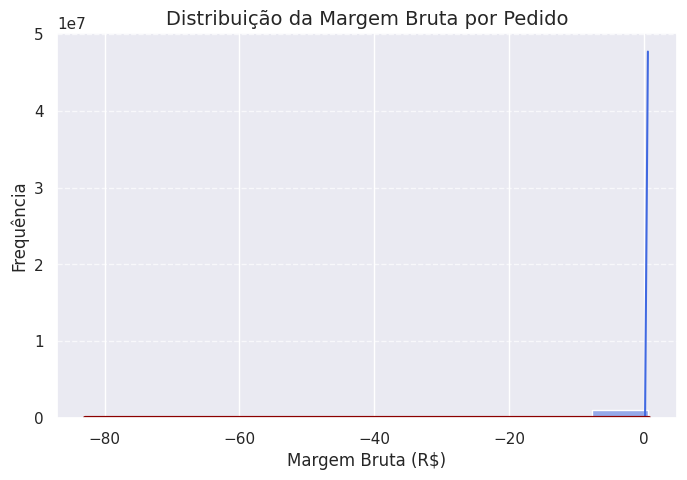

In [17]:
# Histograma
plt.figure(figsize=(8, 5))
sns.histplot(df['Margem_bruta'], bins=10, kde=True, color='royalblue')
sns.kdeplot(df['Margem_bruta'], color='darkred', linewidth=3)
# Personalização
plt.title('Distribuição da Margem Bruta por Pedido', fontsize=14)
plt.xlabel('Margem Bruta (R$)')
plt.ylabel('Frequência')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Podemos notar que temos um pico acima do zero, contudo temos indicativo margem de lucro negativa, o que nos indica que o valor recebido pelo pedido **não cobre** o custo de aquisição do produto/produção e **nem o frete**.

Vamos criar duas categorias para facilitar a comparação. Neste caso, teremos dois grupos iniciais:
- **Grupo 1:** Pedidos lucrativos (Margem_bruta >= 0)
- **Grupo 2:** Pedidos com prejuízo (Margem_bruta < 0)

In [18]:
# Criar coluna de categoria
df['Status_Margem'] = df['Margem_bruta'].apply(lambda x: 'Lucro' if x >= 0 else 'Prejuízo')

In [19]:
print(df['Status_Margem'].value_counts(normalize=True)*100)

Status_Margem
Lucro       99.246597
Prejuízo     0.753403
Name: proportion, dtype: float64


Temos que 99% dos pedidos geram lucros e apenas 0.75%, menos de 1% gera prejuízo.

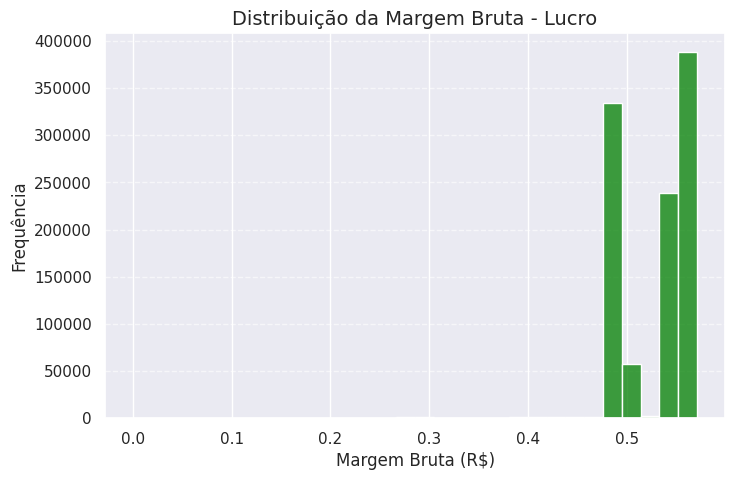

In [20]:
plt.figure(figsize=(8, 5))
sns.histplot(df[df['Status_Margem'] == 'Lucro']['Margem_bruta'], bins=30, color='green')
plt.title('Distribuição da Margem Bruta - Lucro', fontsize=14)
plt.xlabel('Margem Bruta (R$)')
plt.ylabel('Frequência')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

Nossa margem lucrativa possuí uma cauda muito longa na esquerda, indo em direção ao zero. Contudo, temos pedidos que gerem Margem Bruta a acima de 40% e abaixo de 60%.

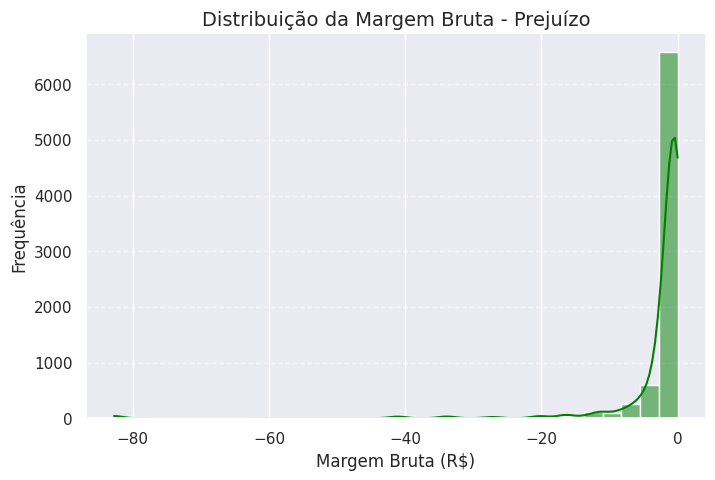

In [21]:
plt.figure(figsize=(8, 5))
sns.histplot(df[df['Status_Margem'] == 'Prejuízo']['Margem_bruta'], kde=True,bins=30, color='green')
plt.title('Distribuição da Margem Bruta - Prejuízo', fontsize=14)
plt.xlabel('Margem Bruta (R$)')
plt.ylabel('Frequência')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

Quando olhamos para os pedidos que indicam prejuízo, temos uma pico bastante alto logo abaixo de zero e uma calda muito longa na esquerda. 

Podemos calcular o total de prejuízo 

In [22]:
Valor_do_prejuízo = float((df[df['Status_Margem'] == 'Prejuízo']['Margem_bruta'] * df['Valor_pedido']).sum())
Valor_do_prejuízo

-14389870.0

Vimos que os pedidos que geram prejuízo representam menos de 1% dos pedidos. Contudo, este valor representa um total de R$ 14,389,870.0. O que nos levar a perguntar por que estes pedidos possuem uma margem bruta negativa. 

In [69]:
lucro = df[df['Status_Margem'] == 'Lucro']
prejuizo = df[df['Status_Margem'] == 'Prejuízo']
prejuizo

,ID_Pedido,Data,Modal,Cidade,Valor_pedido,Distancia,Peso_Kg,Preco_custo,Custo_Frete,Margem_bruta,custo_frete_por_pedido,custo_frete_por_kg,custo_frete_por_km,Markup,kg_por_km,Valor_por_km,Custo_frete_por_KgKm,Custo_frete_sobre_preco_custo,Status_Margem
98,F99,2023-02-25,Dedicado,Florianopolis,1380,766,23,575,5000,-3.039855,3.623188,217.391304,6.527415,2.4,0.030026,1.801567,0.283801,8.695652,Prejuízo
99,F100,2023-04-06,Dedicado,Florianopolis,2880,824,48,1200,5000,-1.152778,1.736111,104.166667,6.067961,2.4,0.058252,3.495146,0.126416,4.166667,Prejuízo
100,F101,2023-07-17,Dedicado,Florianopolis,1740,850,29,725,5000,-2.290230,2.873563,172.413793,5.882353,2.4,0.034118,2.047059,0.202840,6.896552,Prejuízo
102,F103,2023-11-03,Dedicado,Florianopolis,2220,841,37,925,5000,-1.668919,2.252252,135.135135,5.945303,2.4,0.043995,2.639715,0.160684,5.405405,Prejuízo
106,F107,2023-01-18,Dedicado,Florianopolis,4560,830,76,1900,5000,-0.513158,1.096491,65.789474,6.024096,2.4,0.091566,5.493976,0.079264,2.631579,Prejuízo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
812069,R12070,2024-07-14,Dedicado,Rio de Janeir,1020,312,17,425,2070,-1.446078,2.029412,121.764706,6.634615,2.4,0.054487,3.269231,0.390271,4.870588,Prejuízo
812092,R12093,2024-07-20,Dedicado,Rio de Janeir,1320,338,22,550,2070,-0.984848,1.568182,94.090909,6.124260,2.4,0.065089,3.905325,0.278375,3.763636,Prejuízo
812094,R12095,2023-12-16,Dedicado,Rio de Janeir,1200,306,20,500,2070,-1.141667,1.725000,103.500000,6.764706,2.4,0.065359,3.921569,0.338235,4.140000,Prejuízo
812096,R12097,2024-08-24,Dedicado,Rio de Janeir,240,316,4,100,2070,-8.041667,8.625000,517.500000,6.550633,2.4,0.012658,0.759494,1.637658,20.700000,Prejuízo


In [49]:
prejuizo.describe()

,Data,Valor_pedido,Distancia,Peso_Kg,Preco_custo,Custo_Frete,Margem_bruta,custo_frete_por_pedido,custo_frete_por_kg,custo_frete_por_km,Markup,kg_por_km,Valor_por_km,Custo_frete_por_KgKm,Custo_frete_sobre_preco_custo
count,7900,7900.000000,7900.000000,7900.000000,7900.000000,7900.000000,7900.000000,7900.000000,7900.000000,7900.000000,7.900000e+03,7900.000000,7900.000000,7900.000000,7900.000000
mean,2023-12-28 22:25:45.721519104,3208.086076,596.269494,53.468101,1336.702532,3692.886076,-2.505510,3.088843,185.330598,6.294690,2.400000e+00,0.091071,5.464277,0.426688,7.413224
min,2023-01-01 00:00:00,60.000000,95.000000,1.000000,25.000000,750.000000,-82.750000,0.584746,35.084746,5.624297,2.400000e+00,0.001134,0.068027,0.039608,1.403390
25%,2023-06-26 00:00:00,1080.000000,335.000000,18.000000,450.000000,2070.000000,-1.716667,0.766667,46.000000,5.917160,2.400000e+00,0.045813,2.748752,0.073331,1.840000
50%,2023-12-29 00:00:00,2640.000000,756.000000,44.000000,1100.000000,5000.000000,-0.558219,1.141553,68.493151,6.242197,2.400000e+00,0.091064,5.463861,0.141355,2.739726
75%,2024-06-28 06:00:00,5100.000000,823.000000,85.000000,2125.000000,5000.000000,-0.183333,2.300000,138.000000,6.596306,2.400000e+00,0.135549,8.132955,0.360332,5.520000
max,2024-12-31 00:00:00,8520.000000,889.000000,142.000000,3550.000000,5000.000000,-0.001412,83.333333,5000.000000,7.894737,2.400000e+00,0.221053,13.263158,7.894737,200.000000
std,NaN,2458.267151,270.561939,40.971119,1024.277979,1636.140223,7.783291,7.783291,466.997468,0.467349,4.441173e-16,0.052341,3.140478,0.942557,18.679899


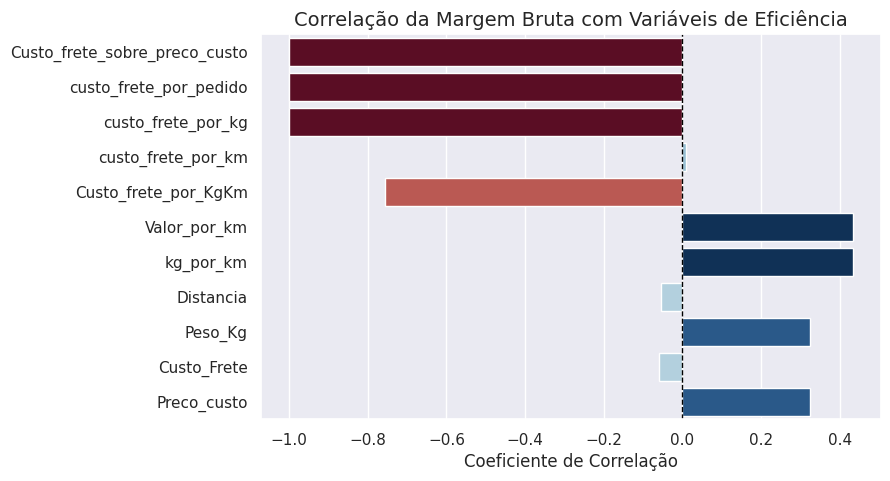

In [74]:
variaveis = [
    'Margem_bruta',
    'Custo_frete_sobre_preco_custo',
    'custo_frete_por_pedido',
    'custo_frete_por_kg',
    'custo_frete_por_km',
    'Custo_frete_por_KgKm',
    'Valor_por_km',
    'kg_por_km',
    'Distancia',
    'Peso_Kg',
    'Custo_Frete',
    'Preco_custo'
]

# Calcular correlação
corr_prej = prejuizo[variaveis].corr()

# Selecionar apenas a correlação com Margem_bruta (excluindo ela mesma)
corr_margem_prej = corr_prej['Margem_bruta'].drop('Margem_bruta')

# Plotar como gráfico de barras
plt.figure(figsize=(8,5))
sns.barplot(x=corr_margem_prej.values, y=corr_margem_prej.index, palette='RdBu', hue=corr_margem_prej.values, dodge=False, legend=False)

plt.title('Correlação da Margem Bruta com Variáveis de Eficiência', fontsize=14)
plt.xlabel('Coeficiente de Correlação')
plt.ylabel('')
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.show()

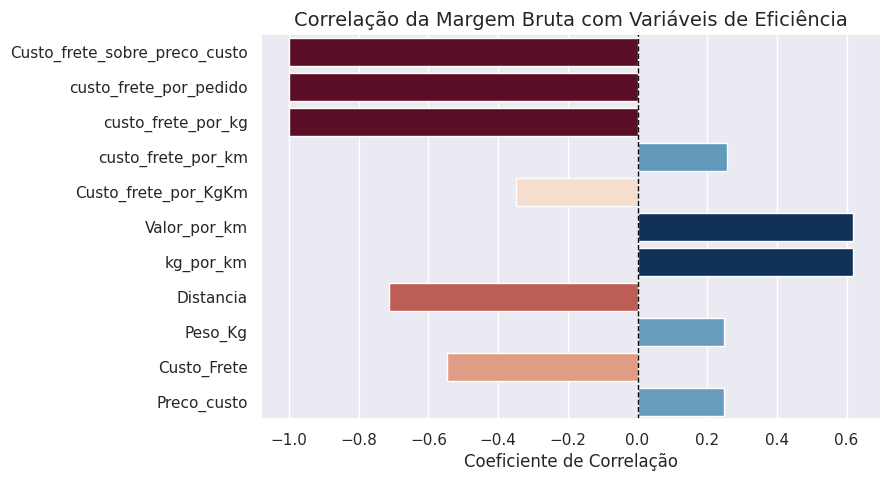

In [75]:

# Calcular correlação
corr_lucro = lucro[variaveis].corr()

# Selecionar apenas a correlação com Margem_bruta (excluindo ela mesma)
corr_margem_lucro = corr_lucro['Margem_bruta'].drop('Margem_bruta')

# Plotar como gráfico de barras
plt.figure(figsize=(8,5))
sns.barplot(x=corr_margem_lucro.values, y=corr_margem_lucro.index, palette='RdBu', hue=corr_margem_lucro.values, dodge=False, legend=False)

plt.title('Correlação da Margem Bruta com Variáveis de Eficiência', fontsize=14)
plt.xlabel('Coeficiente de Correlação')
plt.ylabel('')
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.show()